In [ ]:
# -------------------------
# 1) Mount Google Drive
# -------------------------
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



=== INPUT: /content/drive/MyDrive/soil_microCT_images/ROI/bnei_reem_ROI_8bit
Found: 652 images


Processing bnei_reem_ROI_8bit:   0%|          | 0/652 [00:00<?, ?it/s]

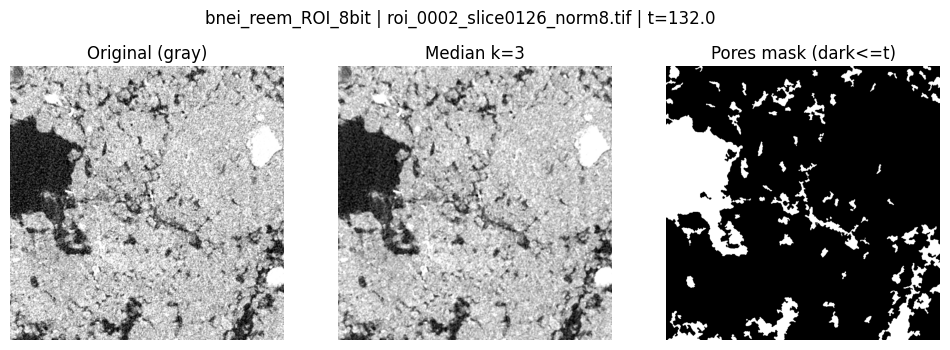

Processing bnei_reem_ROI_8bit:   0%|          | 1/652 [00:00<04:33,  2.38it/s]

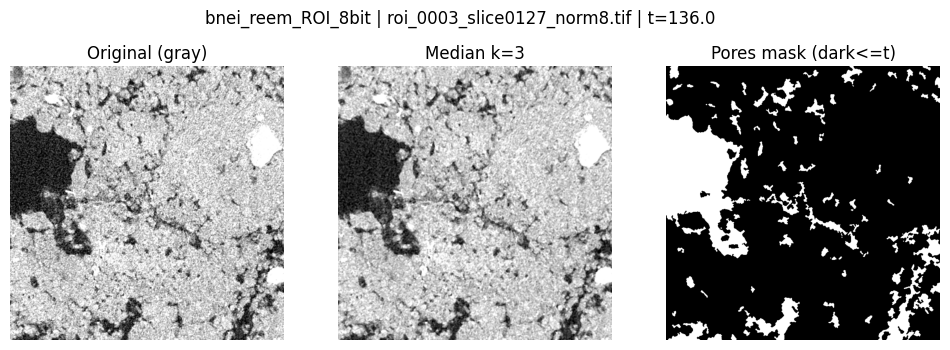

Processing bnei_reem_ROI_8bit:   0%|          | 2/652 [00:00<04:26,  2.44it/s]

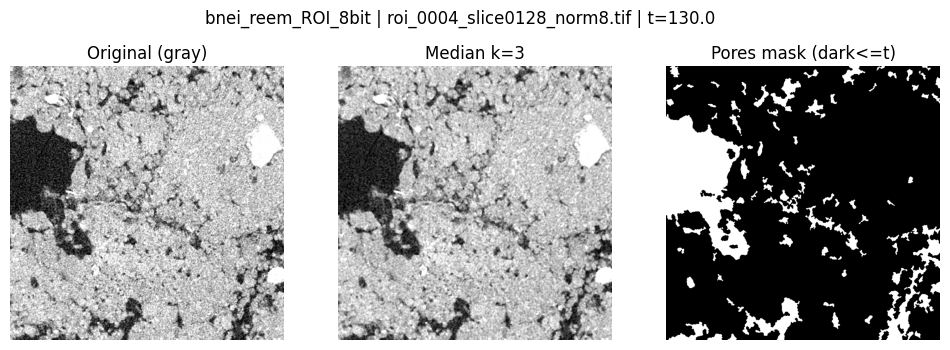

Processing bnei_reem_ROI_8bit: 100%|██████████| 652/652 [01:23<00:00,  7.78it/s]



=== INPUT: /content/drive/MyDrive/soil_microCT_images/ROI/mishmar_hanegev_maoz_ROI_8bit
Found: 1203 images


Processing mishmar_hanegev_maoz_ROI_8bit:   0%|          | 0/1203 [00:00<?, ?it/s]

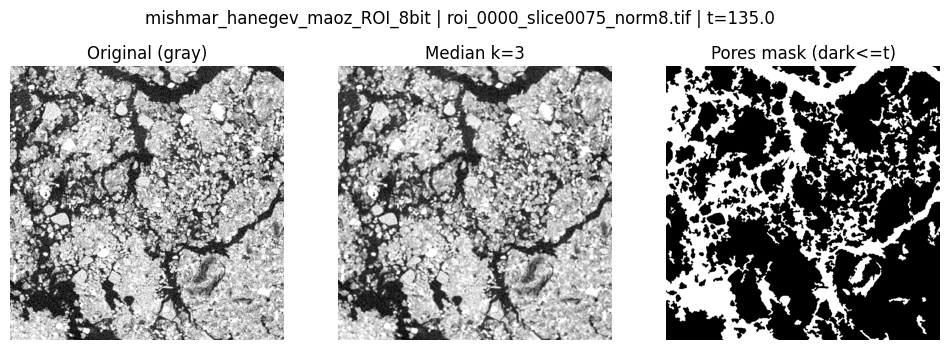

Processing mishmar_hanegev_maoz_ROI_8bit:   0%|          | 1/1203 [00:00<16:17,  1.23it/s]

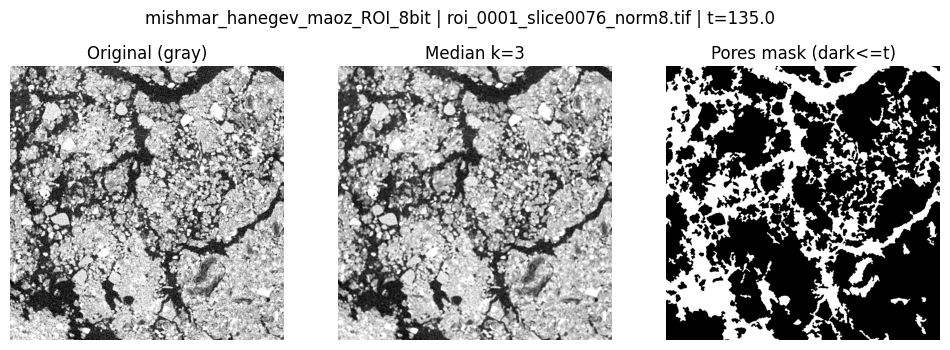

Processing mishmar_hanegev_maoz_ROI_8bit:   0%|          | 2/1203 [00:01<14:47,  1.35it/s]

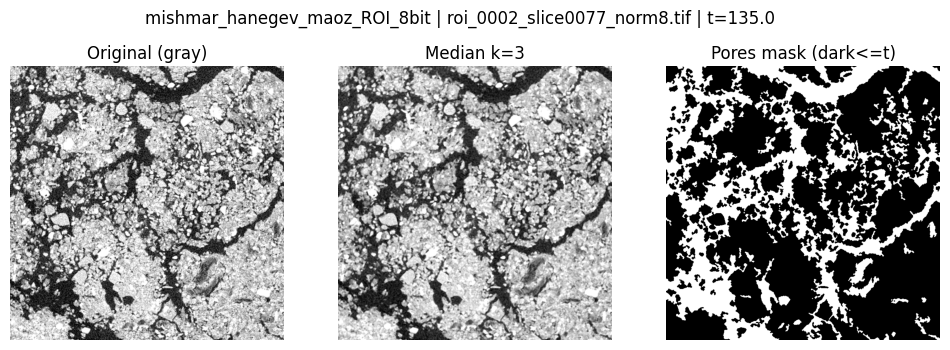

Processing mishmar_hanegev_maoz_ROI_8bit: 100%|██████████| 1203/1203 [02:58<00:00,  6.74it/s]



=== INPUT: /content/drive/MyDrive/soil_microCT_images/ROI/rehovot_ROI_8bit
Found: 661 images


Processing rehovot_ROI_8bit:   0%|          | 0/661 [00:00<?, ?it/s]

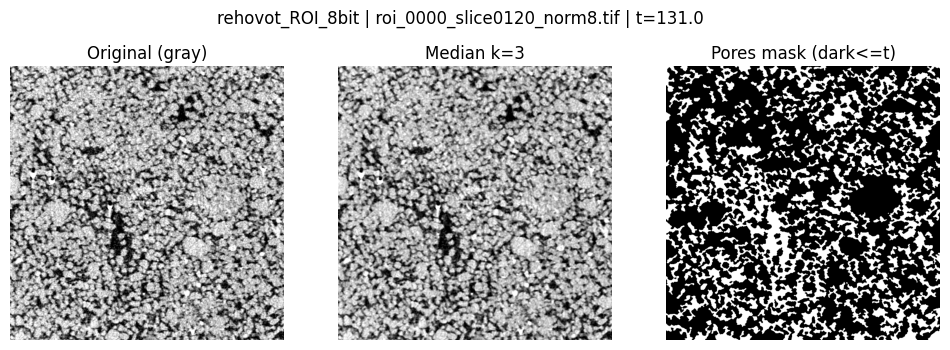

Processing rehovot_ROI_8bit:   0%|          | 1/661 [00:01<14:17,  1.30s/it]

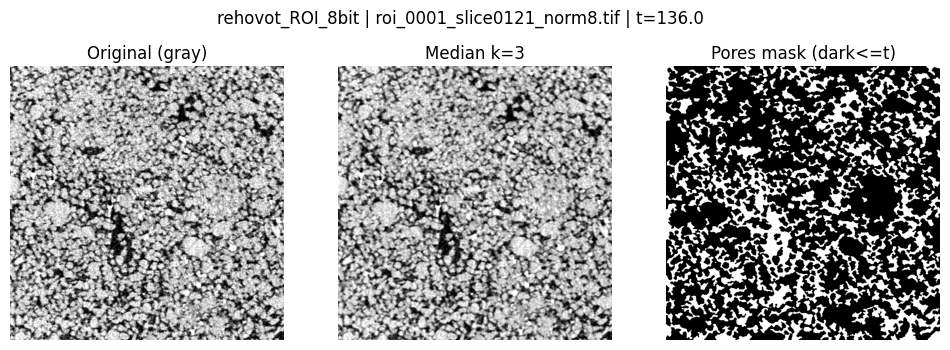

Processing rehovot_ROI_8bit:   0%|          | 2/661 [00:02<13:21,  1.22s/it]

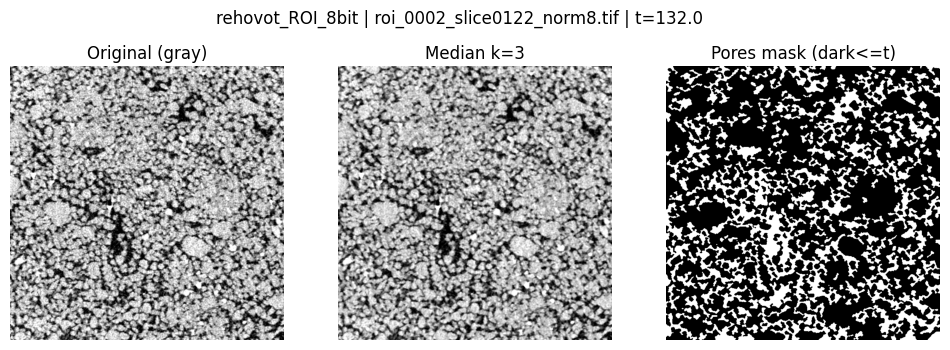

Processing rehovot_ROI_8bit: 100%|██████████| 661/661 [03:06<00:00,  3.55it/s]


=== THRESHOLD STATS (per folder) ===
bnei_reem_ROI_8bit {'n': 652, 'mean_t': 134.75613496932516, 'std_t': 5.9987505677783695, 'min_t': 126.0, 'max_t': 158.0}
mishmar_hanegev_maoz_ROI_8bit {'n': 1203, 'mean_t': 134.0648379052369, 'std_t': 4.167217849833747, 'min_t': 121.0, 'max_t': 146.0}
rehovot_ROI_8bit {'n': 661, 'mean_t': 133.55673222390317, 'std_t': 2.8126369636453603, 'min_t': 125.0, 'max_t': 146.0}

Done ✅ Output root: /content/drive/MyDrive/soil_microCT_images/ROI/otsu_pores_outputs


In [ ]:
# =========================
# COLAB: DARK PORES SEGMENTATION WITH OTSU (3 INPUT FOLDERS -> 3 OUTPUT FOLDERS)
# =========================
# What it does:
# 1) Reads all images from 3 input folders on Google Drive
# 2) For each image: grayscale -> (optional) median -> Otsu threshold
# 3) Because pores are DARK: pores = gray <= threshold
# 4) Cleans mask (remove small objects/holes + optional open/close)
# 5) Saves:
#    - pores mask as PNG
#    - optional overlay preview image (original with pores highlighted)
# 6) Creates output folders automatically if missing

!pip -q install opencv-python-headless scikit-image matplotlib tqdm

import os
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects, remove_small_holes


# -------------------------
# 2) CONFIG: set your 3 input folders and output root
# -------------------------
INPUT_FOLDERS = [
    "/content/drive/MyDrive/soil_microCT_images/ROI/bnei_reem_ROI_8bit",
    "/content/drive/MyDrive/soil_microCT_images/ROI/mishmar_hanegev_maoz_ROI_8bit",
    "/content/drive/MyDrive/soil_microCT_images/ROI/rehovot_ROI_8bit",
]

OUTPUT_ROOT = "/content/drive/MyDrive/soil_microCT_images/ROI/otsu_pores_outputs"

# Median filter kernel (0 to disable). Typical: 3 or 5
MEDIAN_K = 3

# Remove tiny specks and fill tiny holes (in pixels)
MIN_PORE_AREA_PX = 80     # increase if too much noise; decrease if real pores disappear
MAX_HOLE_AREA_PX = 80     # increase if pores are too "hole-y"; decrease if it overfills

# Optional morphology cleanup (0 to disable)
MORPH_OPEN_K = 3          # removes small white noise on mask edges
MORPH_CLOSE_K = 3         # closes small gaps

# Save overlay images too?
SAVE_OVERLAY = True

# Preview how many images per folder
PREVIEW_N = 3

# File extensions to process
EXTS = {".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp"}

# -------------------------
# Helpers
# -------------------------
def ensure_dir(p: str):
    Path(p).mkdir(parents=True, exist_ok=True)

def list_images(folder: str):
    folder = Path(folder)
    files = []
    if not folder.exists():
        return files
    for f in folder.iterdir():
        if f.is_file() and f.suffix.lower() in EXTS:
            files.append(str(f))
    return sorted(files)

def apply_morph(mask_u8: np.ndarray, open_k: int, close_k: int):
    out = mask_u8.copy()
    if open_k and open_k > 1:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_k, open_k))
        out = cv2.morphologyEx(out, cv2.MORPH_OPEN, k)
    if close_k and close_k > 1:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_k, close_k))
        out = cv2.morphologyEx(out, cv2.MORPH_CLOSE, k)
    return out

def make_overlay(gray: np.ndarray, mask_u8: np.ndarray, alpha=0.35):
    # # Convert grayscale to BGR for overlay
    bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    overlay = bgr.copy()
    # # Highlight pores in red channel
    overlay[mask_u8 > 0] = (0, 0, 255)  # BGR: red
    # # Blend
    out = cv2.addWeighted(overlay, alpha, bgr, 1 - alpha, 0)
    return out

def show_preview(gray, filtered, mask_u8, title):
    plt.figure(figsize=(12, 4))
    plt.suptitle(title)
    plt.subplot(1, 3, 1)
    plt.imshow(gray, cmap="gray")
    plt.title("Original (gray)")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(filtered, cmap="gray")
    plt.title(f"Median k={MEDIAN_K}" if MEDIAN_K else "No filter")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(mask_u8, cmap="gray")
    plt.title("Pores mask (dark<=t)")
    plt.axis("off")
    plt.show()

# -------------------------
# 3) Main: process folders
# -------------------------
ensure_dir(OUTPUT_ROOT)

stats = {}

for in_dir in INPUT_FOLDERS:
    in_dir = in_dir.strip()
    folder_name = Path(in_dir).name if in_dir else "EMPTY"

    imgs = list_images(in_dir)
    print(f"\n=== INPUT: {in_dir}")
    print(f"Found: {len(imgs)} images")

    out_dir = os.path.join(OUTPUT_ROOT, folder_name)
    ensure_dir(out_dir)

    out_mask_dir = os.path.join(out_dir, "masks")
    ensure_dir(out_mask_dir)

    out_overlay_dir = os.path.join(out_dir, "overlays")
    if SAVE_OVERLAY:
        ensure_dir(out_overlay_dir)

    thresholds = []
    preview_done = 0

    for img_path in tqdm(imgs, desc=f"Processing {folder_name}"):
        gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if gray is None:
            continue

        # 1) Optional median filtering (helps speckle noise)
        if MEDIAN_K and MEDIAN_K > 1:
            filtered = cv2.medianBlur(gray, MEDIAN_K)
        else:
            filtered = gray

        # 2) Otsu threshold
        t = threshold_otsu(filtered)
        thresholds.append(float(t))

        # 3) Dark pixels are pores
        pores_bool = (filtered <= t)

        # 4) Clean mask: remove tiny holes and tiny objects
        pores_bool = remove_small_holes(pores_bool, area_threshold=MAX_HOLE_AREA_PX)
        pores_bool = remove_small_objects(pores_bool, min_size=MIN_PORE_AREA_PX)

        mask_u8 = (pores_bool.astype(np.uint8) * 255)

        # 5) Optional morphology cleanup
        mask_u8 = apply_morph(mask_u8, MORPH_OPEN_K, MORPH_CLOSE_K)

        # 6) Save mask
        base = Path(img_path).stem
        out_mask_path = os.path.join(out_mask_dir, f"{base}_pores_otsu.png")
        cv2.imwrite(out_mask_path, mask_u8)

        # 7) Save overlay
        if SAVE_OVERLAY:
            ov = make_overlay(gray, mask_u8, alpha=0.35)
            out_ov_path = os.path.join(out_overlay_dir, f"{base}_overlay.png")
            cv2.imwrite(out_ov_path, ov)

        # 8) Preview a few
        if preview_done < PREVIEW_N:
            show_preview(gray, filtered, mask_u8, title=f"{folder_name} | {Path(img_path).name} | t={t:.1f}")
            preview_done += 1

    # Stats for this folder
    if thresholds:
        stats[folder_name] = {
            "n": len(thresholds),
            "mean_t": float(np.mean(thresholds)),
            "std_t": float(np.std(thresholds)),
            "min_t": float(np.min(thresholds)),
            "max_t": float(np.max(thresholds)),
        }

print("\n=== THRESHOLD STATS (per folder) ===")
for k, v in stats.items():
    print(k, v)

print("\nDone ✅ Output root:", OUTPUT_ROOT)
